### 1- Create an SQL query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features

In [1]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import getpass
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
password = getpass.getpass()

········


In [2]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)
query = '''
        SELECT f.film_id, f.release_year, f.rental_rate, f.length, f.rating, r.rental_id, r.rental_date, r.customer_id, c.name
        FROM film f
        JOIN inventory i
        ON f.film_id = i.film_id
        JOIN rental r
        ON i.inventory_id = r.inventory_id
        JOIN film_category fc
        ON f.film_id = fc.film_id
        JOIN category c
        ON fc.category_id = c.category_id;
        '''

### 2- Read the data into a Pandas dataframe

In [3]:
data = pd.read_sql_query(query, engine)
data

,film_id,release_year,rental_rate,length,rating,rental_id,rental_date,customer_id,name
0,19,2006,0.99,113,PG,10895,2005-08-02 01:16:59,77,Action
1,19,2006,0.99,113,PG,12268,2005-08-18 04:26:54,39,Action
2,19,2006,0.99,113,PG,3150,2005-06-20 20:35:28,34,Action
3,19,2006,0.99,113,PG,5072,2005-07-09 05:01:58,254,Action
4,19,2006,0.99,113,PG,9080,2005-07-30 08:02:39,276,Action
...,...,...,...,...,...,...,...,...,...
16056,989,2006,4.99,74,R,962,2005-05-30 18:45:17,520,Travel
16057,989,2006,4.99,74,R,1292,2005-06-15 09:03:52,178,Travel
16058,989,2006,4.99,74,R,4108,2005-07-07 06:38:31,66,Travel
16059,989,2006,4.99,74,R,8871,2005-07-30 00:12:41,382,Travel


### 3- Analyze extracted features and transform them. You may need to encode some categorical variables, or scale numerical variables

In [4]:
data.head()

,film_id,release_year,rental_rate,length,rating,rental_id,rental_date,customer_id,name
0,19,2006,0.99,113,PG,10895,2005-08-02 01:16:59,77,Action
1,19,2006,0.99,113,PG,12268,2005-08-18 04:26:54,39,Action
2,19,2006,0.99,113,PG,3150,2005-06-20 20:35:28,34,Action
3,19,2006,0.99,113,PG,5072,2005-07-09 05:01:58,254,Action
4,19,2006,0.99,113,PG,9080,2005-07-30 08:02:39,276,Action


In [5]:
data.shape

(16061, 9)

In [6]:
data['rental_id'].duplicated().any()

False

In [7]:
data = data.set_index('rental_id')

In [8]:
data.dtypes

film_id                  int64
release_year             int64
rental_rate            float64
length                   int64
rating                  object
rental_date     datetime64[ns]
customer_id              int64
name                    object
dtype: object

In [9]:
data['rating'].value_counts()

PG-13    3585
NC-17    3293
PG       3229
R        3181
G        2773
Name: rating, dtype: int64

In [10]:
data['name'].value_counts()

Sports         1179
Animation      1166
Action         1112
Sci-Fi         1101
Family         1096
Documentary    1067
Drama          1060
Foreign        1033
Games           969
Children        945
Comedy          941
New             940
Classics        939
Horror          846
Travel          837
Music           830
Name: name, dtype: int64

In [11]:
data.describe()

,film_id,release_year,rental_rate,length,customer_id
count,16061.000000,16061.0,16061.000000,16061.000000,16061.000000
mean,500.579541,2006.0,2.940563,114.940415,296.966254
std,288.818995,0.0,1.650026,40.092187,172.447511
min,1.000000,2006.0,0.990000,46.000000,1.000000
25%,254.000000,2006.0,0.990000,81.000000,147.000000
50%,496.000000,2006.0,2.990000,113.000000,295.000000
75%,753.000000,2006.0,4.990000,148.000000,446.000000
max,1000.000000,2006.0,4.990000,185.000000,599.000000


In [12]:
data.isna().sum()

film_id         0
release_year    0
rental_rate     0
length          0
rating          0
rental_date     0
customer_id     0
name            0
dtype: int64

In [13]:
# dropping release_year as it is only 2006 (std = 0)
data = data.drop(['release_year'], axis=1)

In [14]:
# transforming rental_rate into a categorical variable as it only takes 3 values
data['rental_rate'] = data['rental_rate'].astype('object')

In [15]:
# categorical variables as dummies
# generate a new dataframe containing only categorical variables
categorical = pd.DataFrame(data.select_dtypes(np.object))

categorical = pd.get_dummies(categorical)

<ipython-input-15-57d7778746b9>:3: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  categorical = pd.DataFrame(data.select_dtypes(np.object))


In [16]:
# generate a new dataframe containing only numerical variables
numerical = pd.DataFrame(data.select_dtypes(np.number))

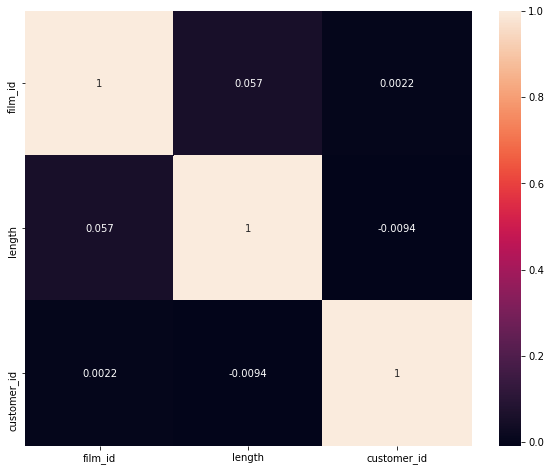

In [17]:
corr_matrix=data.corr(method='pearson')  
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

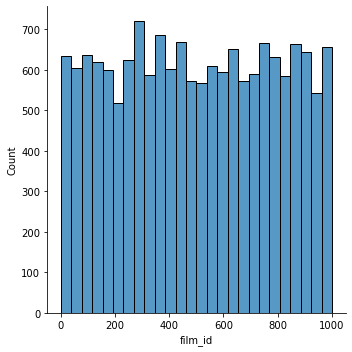

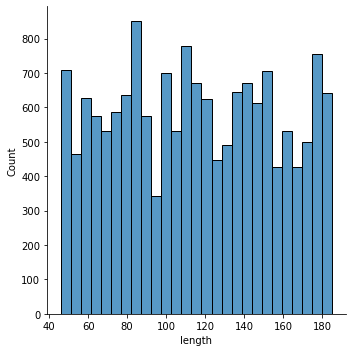

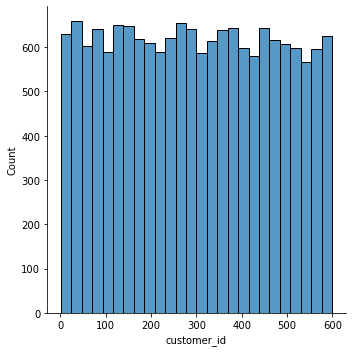

In [18]:
for col in data.select_dtypes(np.number):
    sns.displot(data[col])
    plt.show()

### 4- Create a query to get the list of films and a boolean indicating if it was rented last month. This would be our target variable

In [19]:
data['rental_month_year'] = data['rental_date'].apply(lambda x: x.strftime('%m-%Y'))
data['rental_month_year'].value_counts()

07-2005    6709
08-2005    5686
06-2005    2311
05-2005    1156
02-2006     182
06-2021      17
Name: rental_month_year, dtype: int64

In [20]:
# 02-2006 is the last month, but due to lack of data between 08-2005 and 02-2006, i will use 08-2005 as the last
# or should i have used lag in this case???

query_target = '''
        SELECT rental_id, 
            CASE WHEN month(rental_date) = 8 THEN 1
            WHEN month(rental_date) != 8 THEN 0
            END AS rented_last_month
            FROM rental;
        '''

In [21]:
data_target = pd.read_sql_query(query_target, engine)
data_target['rented_last_month'].value_counts()

0    10375
1     5686
Name: rented_last_month, dtype: int64

In [22]:
# setting rental_id as index for data_target dataframe, then merging on the index with numerical & categorical df's

data_target = data_target.set_index('rental_id')

In [23]:
df = pd.merge(numerical, categorical, left_index=True, right_index=True)
df

,film_id,length,customer_id,rental_rate_0.99,rental_rate_2.99,rental_rate_4.99,rating_G,rating_NC-17,rating_PG,rating_PG-13,...,name_Drama,name_Family,name_Foreign,name_Games,name_Horror,name_Music,name_New,name_Sci-Fi,name_Sports,name_Travel
rental_id,,,,,,,,,,,,,,,,,,,,,
10895,19,113,77,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
12268,19,113,39,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3150,19,113,34,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5072,19,113,254,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
9080,19,113,276,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
962,989,74,520,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1292,989,74,178,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4108,989,74,66,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [24]:
df_target = pd.merge(df, data_target, left_index=True, right_index=True)
df_target

,film_id,length,customer_id,rental_rate_0.99,rental_rate_2.99,rental_rate_4.99,rating_G,rating_NC-17,rating_PG,rating_PG-13,...,name_Family,name_Foreign,name_Games,name_Horror,name_Music,name_New,name_Sci-Fi,name_Sports,name_Travel,rented_last_month
rental_id,,,,,,,,,,,,,,,,,,,,,
10895,19,113,77,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
12268,19,113,39,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3150,19,113,34,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5072,19,113,254,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
9080,19,113,276,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
962,989,74,520,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1292,989,74,178,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4108,989,74,66,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


### 5- Create a logistic regression model to predict this variable from the cleaned data

In [25]:
y = df_target['rented_last_month']
X = df_target.drop('rented_last_month', axis=1)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
classification = LogisticRegression(random_state=42, multi_class='ovr', max_iter=500) 
classification.fit(X_train, y_train)

LogisticRegression(max_iter=500, multi_class='ovr', random_state=42)

### 6- Evaluate the results (calculate the score of the model)

In [28]:
classification.score(X_test, y_test)

0.6230936819172114

In [29]:
predictions = classification.predict(X_test)

pd.Series(predictions).value_counts()

0    3213
dtype: int64

In [30]:
y_test.value_counts()

0    2002
1    1211
Name: rented_last_month, dtype: int64

In [31]:
confusion_matrix(y_test, predictions)

array([[2002,    0],
       [1211,    0]])

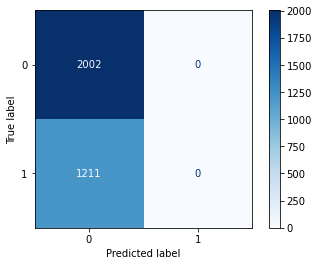

In [32]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(classification, X_test, y_test, cmap='Blues')
plt.show()

In [33]:
# well this is not right, it doesn't give any predictions for which movies will be rented
# i feel really really lost, what am i doing wrong?